In [ ]:
# Датасет mtg-jamendo 
#
# Клонировал репозиторий
#
# git clone https://github.com/MTG/mtg-jamendo-dataset.git
# cd mtg-jamendo-dataset
#
# Дальше создал среду, чтобы скачать один требуемый пакет
#
# uv init
# source .venv/bin/activate
# uv add gdown
#
# Затем скачал сам датасет
#
# python3 scripts/download/download.py --dataset autotagging_moodtheme --type audio-low ../mtg-jamendo-dataset/datasets --unpack --remove


# Аудиофайлы в датасете были с дополнительным .low перед .mp3 в названии
# Поэтому я переименовал все файлы убрав .low, чтобы названия полностью совпадали с таблицей c mood/theme

# import os

# _path = "../data/mtg-jamendo/audio/"
# for i in range(100):
    
#     path = _path + str(i).zfill(2)

#     for f in os.listdir(path):
#         old = os.path.join(path, f)
#         if os.path.isfile(old) and '.low.' in f:
#             new = os.path.join(path, f.replace('.low.', '.'))
#             os.rename(old, new)

In [ ]:
# Этот датасет весит около 50гб, даже с выбранным низким качеством
# Поэтому я решил укоротить аудиофайлы до 30 секунд в рандомном месте вырезая этот самый 30 секундный кусок

# import os
# import librosa
# import soundfile as sf
# import random

# def cut_random_30s(input_dir, output_dir):
#     file_count = 0
#     for root, dirs, files in os.walk(input_dir):
#         for file in files:
#             if file.endswith(('.mp3', '.wav', '.flac')):
#                 input_path = os.path.join(root, file)
#                 relative_path = os.path.relpath(root, input_dir)
#                 output_subdir = os.path.join(output_dir, relative_path)
#                 os.makedirs(output_subdir, exist_ok=True)
                
#                 try:
#                     audio, sr = librosa.load(input_path, sr=None)
#                     total_duration = len(audio) / sr
                    
#                     if total_duration > 30:
#                         max_start = total_duration - 30
#                         start_time = random.uniform(0, max_start)
#                         start_sample = int(start_time * sr)
#                         end_sample = start_sample + 30 * sr
#                         audio_30s = audio[start_sample:end_sample]
#                     else:
#                         audio_30s = audio
                    
#                     output_path = os.path.join(output_subdir, file)
#                     sf.write(output_path, audio_30s, sr)
#                     file_count += 1
#                     print(f"Processed: {input_path}  {100 * file_count / len(files):.2f}%")
#                 except Exception as e:
#                     print(f"Error with {input_path}: {str(e)}")

# input_dir = "../data/mtg-jamendo/audio/"
# output_dir = "../data/temp/"
# for i in range(3, 100):
#     cut_random_30s(input_dir + str(i).zfill(2), output_dir + str(i).zfill(2))


# Теперь датасет весит 5.6гб, надеюсь обучение будет не слишком долгим (целых два с половиной часа ушло на урезание датасета...)


/home/egr/projects/nmus/.venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/egr/projects/nmus/.venv/lib/python3.12/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3

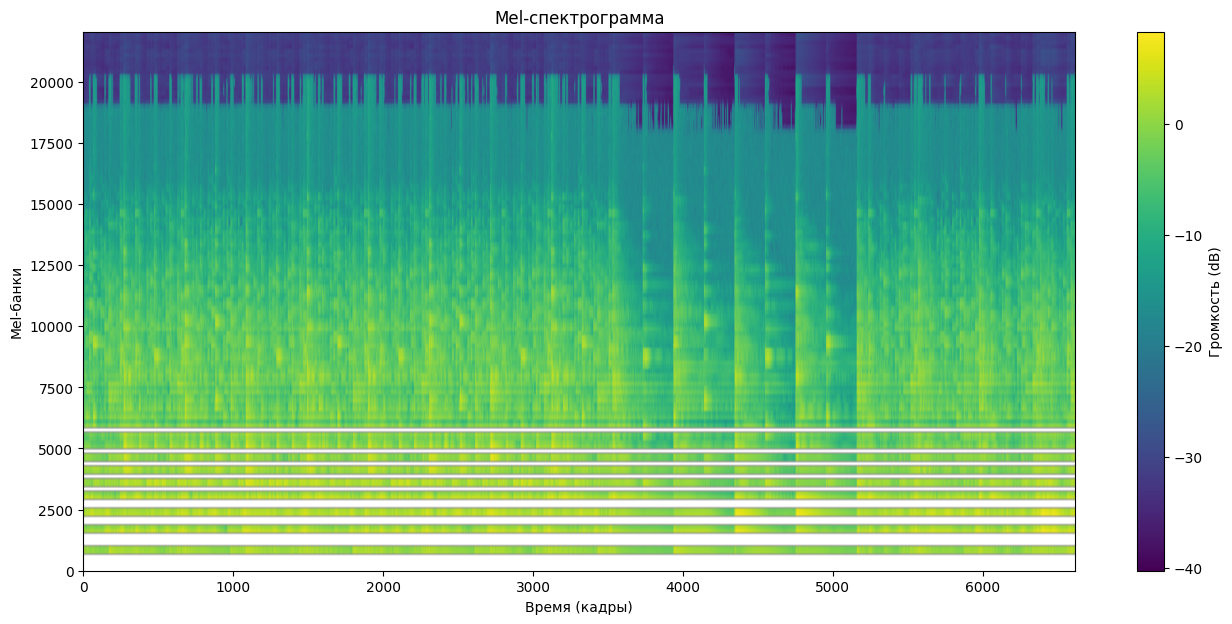

In [52]:
# Теперь попробуем загрузить и визуализировать аудифайл

import torchaudio
import matplotlib.pyplot as plt
import torch
import librosa

# Загрузил первый же аудиофайл
waveform, sr = torchaudio.load("../data/train/00/95400.mp3")

# Создал Mel-спектрограмму для более правдоподобной картины (для человеческого слуха)
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(waveform)

# Человек воспринимает звук логарифмически если по-простому, поэтому логарифмируем, а потом преобразуем в numpy массив (матрицу), ибо matplotlib не воспринимает тензор
data = mel_spectrogram.log2()[0,:,:].numpy()

# Визуализация
plt.figure(figsize=(16, 7))
mel_freqs = librosa.mel_frequencies(n_mels=data.shape[0], fmin=0, fmax=sr/2)
plt.imshow(data, cmap='viridis', origin='lower', aspect='auto',
           extent=[0, data.shape[1], mel_freqs[0], mel_freqs[-1]])
plt.colorbar(label='Громкость (dB)')
plt.title("Mel-спектрограмма")
plt.xlabel("Время (кадры)")
plt.ylabel("Mel-банки")
plt.show()

In [ ]:
# через pandas никак не могу загрузить нормально файл (либо ошибка, либо обрезает теги), поэтому вручную построчно считываю
import pickle

data = []
with open('../data/autotagging_moodtheme.tsv', 'r', encoding='utf-8') as f:
    header = f.readline().strip().split('\t')
    
    for line in f:
        columns = line.strip().split('\t')
        
        # Основные данные (первые 6 колонок)
        track_data = {
            'TRACK_ID': columns[0],
            'ARTIST_ID': columns[1],
            'ALBUM_ID': columns[2],
            'PATH': columns[3],
            'DURATION': float(columns[4]),
            'tags': []
        }
        
        # Все остальные колонки - теги
        for tag in columns[5:]:
            if tag:  # если тег не пустой
                track_data['tags'].append(tag)
        
        data.append(track_data)

print(f"Прочитано {len(data)} треков")

# И создам ещё словарь, который скорее всего сохраню, чтобы было удобнее потом работать с ним
tracks = {}

for item in data:
    # track_id - это track_ + 7 цифр, цифры совпадают с названием аудифайла, но в id надо добавить нули до 7 цифр
    # например название файла 7400.mp3, значит его id будет track_0007400
    track_id = item['TRACK_ID']
    mood_theme = set()
    
    #избавляемся от ненужной приставки
    for tag in item['tags']:
        mood_theme.add(tag.replace('mood/theme---', ''))

    #тут ещё поменял всем длительность, ибо вручную обрезал до 30 секунд все аудио
    tracks[track_id] = {
        'artist_id': item['ARTIST_ID'],
        'album_id': item['ALBUM_ID'],
        'path': item['PATH'],
        'duration': 30.0,
        'mood_theme': mood_theme,
    }

print(f"Создано {len(tracks)} треков в словаре")
print("Пример трека из словаря:")
print(list(tracks.values())[30])

#сохраняем на будущее
with open("../data/tracks.pkl", 'wb') as f:
    pickle.dump(tracks, f)

# для загрузки словаря
# with open("../data/tracks.pkl", 'rb') as f:
#     tracks = pickle.load(f)

Прочитано 18486 треков
Создано 18486 треков в словаре
Пример трека из словаря:
{'artist_id': 'artist_000811', 'album_id': 'album_000867', 'path': '38/5638.mp3', 'duration': 30.0, 'mood_theme': {'documentary', 'emotional', 'space'}}


Теги и их количество: {'background': 496, 'film': 1502, 'melancholic': 441, 'calm': 457, 'melodic': 1213, 'children': 456, 'relaxing': 1350, 'meditative': 742, 'cool': 251, 'documentary': 612, 'emotional': 1271, 'space': 503, 'love': 909, 'drama': 424, 'adventure': 448, 'heavy': 156, 'dark': 1202, 'soft': 465, 'energetic': 1357, 'retro': 213, 'ballad': 334, 'advertising': 673, 'epic': 982, 'action': 407, 'dramatic': 317, 'upbeat': 444, 'powerful': 238, 'inspiring': 877, 'uplifting': 693, 'soundscape': 480, 'slow': 437, 'deep': 635, 'fun': 480, 'horror': 158, 'nature': 259, 'funny': 203, 'happy': 1657, 'positive': 539, 'sad': 749, 'summer': 505, 'dream': 951, 'romantic': 627, 'hopeful': 216, 'mellow': 154, 'motivational': 635, 'party': 266, 'groovy': 194, 'corporate': 609, 'sport': 297, 'travel': 171, 'sexy': 122, 'movie': 413, 'fast': 119, 'commercial': 428, 'holiday': 176, 'ambiental': 460, 'christmas': 623, 'game': 261, 'trailer': 270}
Всего тегов: 32527
Количество различных тегов: 5

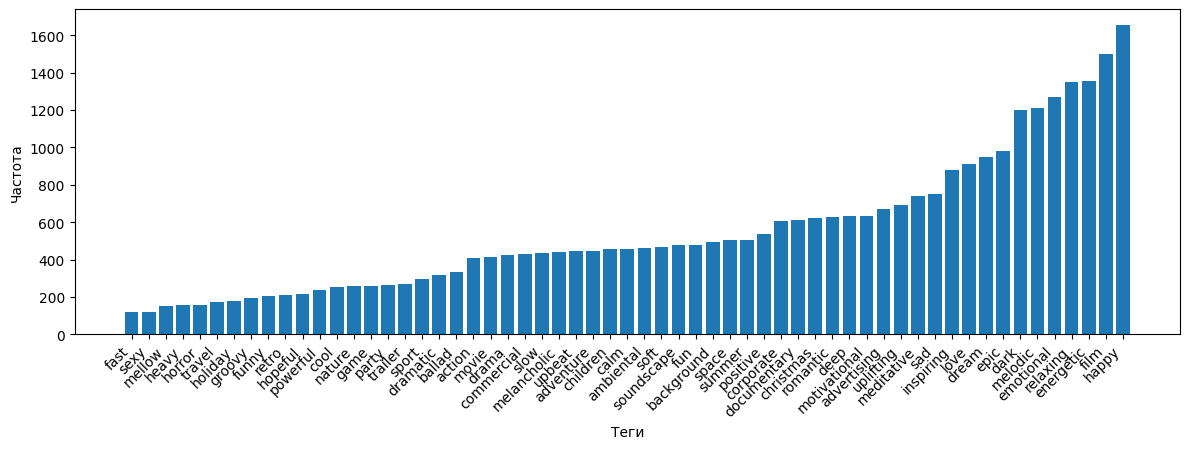

In [ ]:
tracks = {}
moodthemes = {}

# открываем подготовленный словрь
with open("../data/tracks.pkl", 'rb') as f:
    tracks = pickle.load(f)

# высчитываем количество каждого отдельного тега в датасете
for key, value in tracks.items():
    for tag in value["mood_theme"]:
        moodthemes.setdefault(tag, 0)
        moodthemes[tag] += 1

# общее количестов тегов
count = 0
for value in moodthemes.values():
    count += value


print(f"Теги и их количество: {moodthemes}")
print(f"Всего тегов: {count}")
print(f"Количество различных тегов: {len(set(moodthemes.keys()))}")

sorted_tags = sorted(moodthemes.items(), key=lambda x: x[1], reverse=False)
tags, counts = zip(*sorted_tags)

# гистограмма тегов
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 2)
plt.bar(tags, counts) 
plt.xlabel('Теги')
plt.ylabel('Частота')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

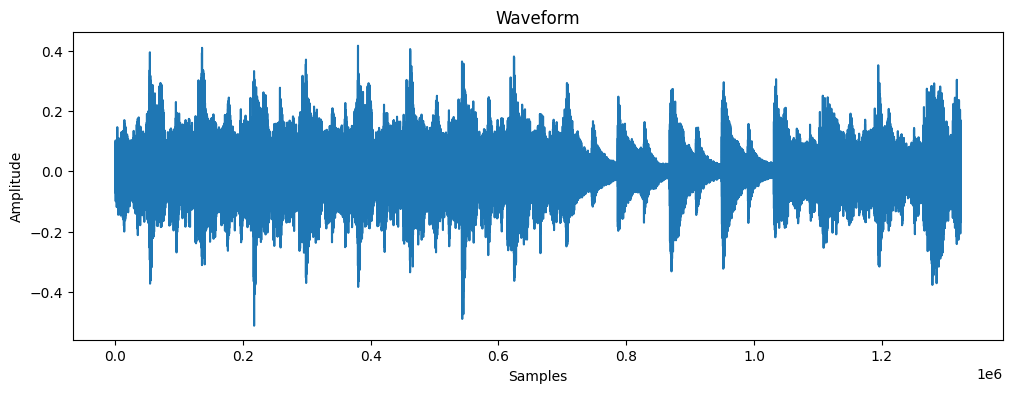

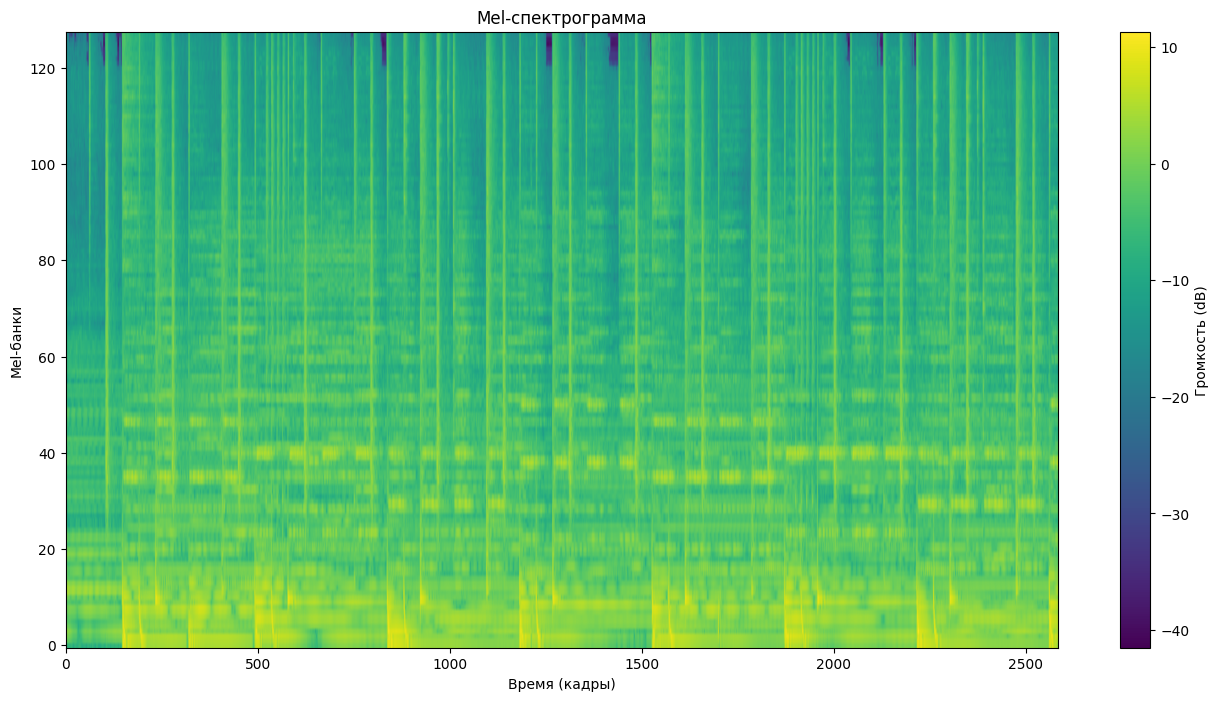

In [ ]:
# А вот уже и то с чем можно будет работать
def preprocess_audio(audio_path, target_sr = 22050) -> torch.Tensor:
    waveform, sr = torchaudio.load(audio_path, normalize=True, channels_first=True)
    #уменьшил частоту дискретизации, чтобы ещё меньше датасет весил, а то везде 44100 Гц или почти везде
    if sr != target_sr:
        waveform = torchaudio.functional.resample(waveform, sr, target_sr)
    
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=22050,
        n_mels=128,        
        n_fft=1024,       
        hop_length=256,
        f_min=20,
        f_max=11000
    )(waveform)
    return mel_spectrogram
    
mel_spektr = preprocess_audio("../data/train/00/7400.mp3")

#waveform
plt.figure(figsize=(12, 4))
plt.plot(waveform[0].numpy())  # первый канал
plt.title("Waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

#mel-спектрограмма
plt.figure(figsize=(16, 8))
plt.imshow(mel_spektr.log2()[0,:,:].numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label='Громкость (dB)')
plt.title("Mel-спектрограмма")
plt.xlabel("Время (кадры)")
plt.ylabel("Mel-банки")
plt.show()
#